# Wine Quality Classification With Artificial Neural Networks

## Introduction
In this notebook, we use neural networks in an attempt to classify the quality of red and white wines based on their physicochemical features and measure results of our classifiers against a quality rating assigned to those wines by human experts. 

#### Import required libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer 
from sklearn.preprocessing import LabelBinarizer
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.metrics import classification_report, make_scorer, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import StratifiedKFold, KFold, cross_val_score, cross_validate, train_test_split, GridSearchCV


In [2]:
# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

The latest Pandas version is required 

In [3]:
# Requires Pandas 1.2.4
#!pip install --upgrade pandas==1.2.4 --user
#pd.__version__

#### Define functions used later

In [4]:
def StandardiseDS(data, omit=[]):
    # Fits numerical data to N(0,1)
    # Note: Remove all non-numerical columns before you call this function.    
    # Inputs: 
    #    data:   Pandas dataframe containing dataset 
    #    omit: Fields to omit
    
    # Returns: Updated dataframe
    if (len(omit)>0):
        temp = data[omit]
        data = data.drop(columns=omit, axis=1)
    column = list(data.columns)
    strdDS = StandardScaler().fit_transform(data)
    strdDF = pd.DataFrame(strdDS, columns=column)
    if (len(omit)>0):
        dataF = pd.concat([strdDF, temp], axis=1)
        return(dataF)
    else:
        return(strdDF)

# A different version of the above
def standardise(data, fields):
    # Fits numerical data to N(0,1)
    
    # Inputs: 
    #    data:   Pandas dataframe containing dataset 
    #    fields: Fields to scale
    
    # Returns: Updated dataset
    
    standardised = pd.DataFrame(StandardScaler().fit_transform(data[fields]))
    standardised.columns = fields
    data = data.drop(columns=fields, axis=1)
    data = pd.concat([standardised, data], axis=1)
    data = data.reset_index(drop=True)
    return data

    
def one_hot_encode(data, fields):
    # One-hot encodes categorical data with n unique values
    # into n new fields
    
    # Inputs: 
    #    data:   Pandas dataframe containing dataset 
    #    fields: Fields to encode
    
    # Returns: Updated dataset
    
    onehot = pd.get_dummies(data[fields])
    data = pd.concat([onehot, data], axis=1)
    data = data.drop(columns=fields, axis=1)
    data = data.reset_index(drop=True)
    return data

def min_max_scaler(data, fields):
    # Scales numerical data into a range (0,1)
    
    # Inputs: 
    #    data:   Pandas dataframe containing dataset 
    #    fields: Fields to scale
    
    # Returns: Updated dataset
    
    scaled = pd.DataFrame(MinMaxScaler().fit_transform(data[fields]))
    scaled.columns = fields
    data = data.drop(columns=fields, axis=1)
    data = pd.concat([scaled, data], axis=1)
    data = data.reset_index(drop=True)
    return data    

def update_results(description, metrics, results_table=pd.DataFrame()):
    
    # Updates results in Pandas dataframe
    
    # Inputs: 
    #    description:   Pandas dataframe containing dataset 
    #    metrics:       Field to be binned
    #    results_table: Required number of bins
    
    # Returns: Updated results table
    
    u = pd.DataFrame(metrics).mean(axis=0)
    v = pd.Series({'Description' : description})
    t = pd.DataFrame(v.append(u)).transpose()
    return results_table.append(t)


def distance_binning(dataset, field, no_of_bins):
    
    # Buckets numerical field data into equally sized bucket thresholds
    # Returns updated dataframe
    
    # Inputs: 
    #    dataset:     Pandas dataframe containing dataset 
    #    field:       Field to be binned
    #    no_of_bins:  Required number of bins
   
    bins = np.linspace(dataset[field].min(),dataset[field].max(),no_of_bins+1)
    labels = [i for i in range(1,no_of_bins+1)]
    dataset_new = dataset.copy()
    dataset_new[field] = pd.cut(dataset_new[field], bins=bins, labels=labels, include_lowest=True)
    return dataset_new

def frequency_binning(dataset, field, no_of_bins):
    
    # Buckets numerical field data into buckets containing roughly equal number of records
    # Returns updated dataframe
    
    # Inputs: 
    #    dataset:     Pandas dataframe containing dataset 
    #    field:       Field to be binned
    #    no_of_bins:  Required number of bins
    
   
    labels = [i for i in range(1,no_of_bins+1)]
    dataset_new = dataset.copy()
    dataset_new[field] = pd.qcut(dataset_new[field], q=no_of_bins, labels=labels)
    return dataset_new


#### Define globals here

In [5]:
# Globals
# Scoring for kfolds cross validation
scoring = {'accuracy' : make_scorer(accuracy_score), 
           'precision' : make_scorer(precision_score, average = 'weighted'),
           'recall' : make_scorer(recall_score, average = 'weighted'), 
           'f1_score' : make_scorer(f1_score, average = 'weighted')} 

# Set variables to hold results for tests to follow
results = []
names = []

#### Load dataset

In [6]:
wine_data = pd.read_csv('winequalityN.csv')

#### Drop rows with missing data
There are around 35 rows in this dataset where one or more fields is null, versus a dataset of size ~6500. There is no obvious commonality between rows with null values and because the number of rows involved is so small, the group decided to simply remove these from the dataset, rather than fill in with average values.

In [7]:
wine_data = wine_data.dropna()
# Reset index so that columns can be merged easily with others later.
# This operation does not change the ordering of rows.
wine_data = wine_data.reset_index(drop=True)

# Check data
wine_data.head()

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,white,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,white,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,white,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,white,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,white,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


##### Comment 
The first few rows all appear to be white wines, which may suggest that the data have been ordered in some way. Remember to shuffle later.

#### Define dataset columns

In [9]:
target_col = ['quality']
continuous_cols = [i for i in wine_data.columns if i not in ['type', 'quality']]
categorical_col = ['type']

#### Check feature correlation
The following heatmap shows the correlation between pairs of continuous numerical fields in the dataset. If two features are highly correlated, negatively or positively, the second may add unnecessary complexity to models without conveying much additional information and it may be beneficial to remove it.

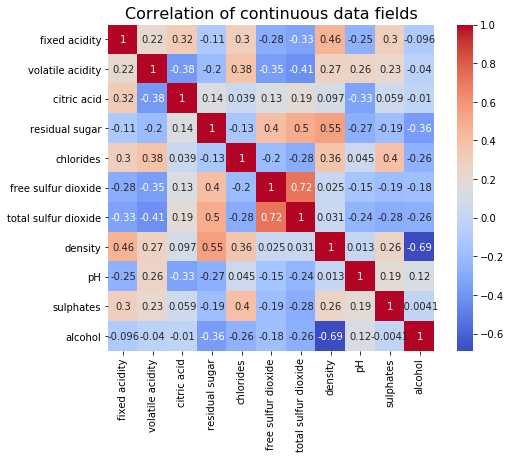

In [67]:
fig, ax = plt.subplots(figsize=(8,6)) 
sns.heatmap(wine_data[continuous_cols].corr(), annot=True, square=True, cmap='coolwarm')
plt.title('Correlation of continuous data fields', size=16)
plt.show()

##### Comment 
The most positively correlated field pairs are 'total sulfur dioxide' with 'free sulfur dioxide' and the most negatively correlated are 'alcohol' and 'density'. Neither pair however are sufficiently correlated to provide a compelling case to remove them, so we retain these fields for the experiments to follow. 

#### Initial data setup
Split dataset into input and target fields.

Set aside an 'unseen' portion of the dataset for final evaluation.

One-hot encode the single categorical input field, 'type'


In [10]:
y = wine_data[target_col]
X = wine_data[categorical_col + continuous_cols]

#Create unseen holdout set for final evaluation
X, X_unseen, y, y_unseen = train_test_split(X, y, test_size=0.1, random_state=19, stratify=y, shuffle=True)

# One-hot encode categorical input
X = one_hot_encode(X,['type'])

# Reset y index for later merging
y = y.reset_index(drop=True)

#### Benchmark Model
Here we train a benchmark single-layer perceptron model, the results from which will be used to gauge the performance of later model variations. 
The only pre-processing is the necessary one-hot encoding of the single categorical input field, 'type'. Input data are neither normalised nor standardised and the model adopts the default parameter settings from the sklearn library.

In [69]:
# Benchmark model

name = 'Benchmark'
model = MLPClassifier(random_state=14)
kfold = StratifiedKFold(n_splits=5, random_state=15, shuffle=True)
metrics = cross_validate(model, X, y.values.ravel(), cv=kfold, scoring = scoring)

results.append(metrics)
names.append(name)
table = update_results(name, metrics)

In [70]:
table

,Description,fit_time,score_time,test_accuracy,test_precision,test_recall,test_f1_score
0,Benchmark,2.960444,0.007605,0.523387,0.506763,0.523387,0.483819


#### Standardise input data
Here, continuous numerical features are fit to a normal distribution with mean 0 and standard deviation 1. Analysis during data exploration for this project revealed that the distributions of wine input features are roughly Gaussian-shaped, so this technique is appropriate so that features of large scale/magnitude do not have a disproportionate effect on distance calculations made during model training. The dataset does have some rows with outlying feature values and the impact of these is at least partially reduced by standardisation. 

In [71]:
# Standardise data
X_exp = standardise(X, continuous_cols)

name = 'Standardised data'
model = MLPClassifier(random_state=14)
kfold = StratifiedKFold(n_splits=5, random_state=15, shuffle=True)
metrics = cross_validate(model, X_exp, y.values.ravel(), cv=kfold, scoring = scoring)

results.append(metrics)
names.append(name)
table = update_results(name, metrics, table)

##### Comment
Standardisation has improved f1_score and accuracy compared with the benchmark model. It is likely that larger-magnitude features such as those related to sulfur dioxide content were having a disproportionate effect on the gradient descent optimiser used in the benchmark model.

In [72]:
table

,Description,fit_time,score_time,test_accuracy,test_precision,test_recall,test_f1_score
0,Benchmark,2.960444,0.007605,0.523387,0.506763,0.523387,0.483819
0,Standardised data,4.971457,0.007531,0.568605,0.557039,0.568605,0.547289


#### Normalise input data
Here, continuous numerical features are fit to a range (0,1). This does not affect the shape of feature distribution but does ensure that features of large scale/magnitude do not have a disproportionate effect on distance calculations made during model training. 

In [73]:
# Normalise data
X_exp = min_max_scaler(X, continuous_cols)

name = 'Normalised data'
model = MLPClassifier(random_state=14)
kfold = StratifiedKFold(n_splits=5, random_state=15, shuffle=True)
metrics = cross_validate(model, X_exp, y.values.ravel(), cv=kfold, scoring = scoring)

results.append(metrics)
names.append(name)
table = update_results(name, metrics, table)

In [74]:
table

,Description,fit_time,score_time,test_accuracy,test_precision,test_recall,test_f1_score
0,Benchmark,2.960444,0.007605,0.523387,0.506763,0.523387,0.483819
0,Standardised data,4.971457,0.007531,0.568605,0.557039,0.568605,0.547289
0,Normalised data,4.281215,0.006807,0.561556,0.5409,0.561556,0.533151


##### Comment
Normalising has improved model performance according to f1 score and accuracy metrics but to a lesser extent than standardisation in the previous experiment. Normalisation does not resolve outliers for the feature vectors in wine data where we have observed extreme values and will just have the effect of "squashing" the distributions into the 0-1 range.


#### Train separate models for red and white wine
Initial data exploration revealed that, not unexpectedly, red and white wines have quite distinct chemical compositions. Plots illustrated that wine of different types could be separated based on one or two features. It is possible therefore that by training separate models on red and white wines, the combined classification performance might improve. We use standardised input data henceforth as this has been shown to improve performance.

In [75]:
# MLP for red wine
X_exp = standardise(X, continuous_cols)
X_red = X_exp[X_exp['type_red']==1]
y_red = y[X_exp['type_red']==1]

name = 'Red wine'
model = MLPClassifier(random_state=14)
kfold = StratifiedKFold(n_splits=5, random_state=15, shuffle=True)
metrics = cross_validate(model, X_red, y_red.values.ravel(), cv=kfold, scoring = scoring)

results.append(metrics)
names.append(name)
table = update_results(name, metrics, table)

In [76]:
# MLP for white wine
X_exp = standardise(X, continuous_cols)
X_white = X_exp[X_exp['type_white']==1]
y_white = y[X_exp['type_white']==1]

name = 'White wine'
model = MLPClassifier(random_state=14)
kfold = StratifiedKFold(n_splits=5, random_state=15, shuffle=True)
metrics = cross_validate(model, X_white, y_white.values.ravel(), cv=kfold, scoring = scoring)

results.append(metrics)
names.append(name)
table = update_results(name, metrics, table)

##### Comment
f1 score and accuracy for the red wine classifier are both significantly higher than those achieved in the previous experiment but metrics for white wine are only slightly lower. However, white wines outnumber red whites in the dataset by over 3 to 1 and when f1 and accuracy are adjusted to account for this, the combination of classifiers is shown not to have improved performance.

In [77]:
table

,Description,fit_time,score_time,test_accuracy,test_precision,test_recall,test_f1_score
0,Benchmark,2.960444,0.007605,0.523387,0.506763,0.523387,0.483819
0,Standardised data,4.971457,0.007531,0.568605,0.557039,0.568605,0.547289
0,Normalised data,4.281215,0.006807,0.561556,0.5409,0.561556,0.533151
0,Red wine,1.10032,0.003586,0.618885,0.591776,0.618885,0.60133
0,White wine,3.369077,0.005807,0.557514,0.538418,0.557514,0.535034


#### Trim outliers
Neural network models can create potentially complex functions to fit data. Where outliers exist in feature vectors, during training, models will attempt to fit these extreme data points and the more complex the model, the more it will be able to.
Here we trim outliers from our dataset by measuring the Euclidean distance of feature vectors from the mean and removing those furthest away.

In [78]:
# Trim outliers according to Euclidean distance from mean
X_std = standardise(X, continuous_cols)

sq = ((X_std[continuous_cols]**2).sum(axis=1))**0.5
#sum(sq>5)
X_exp = X_std[(sq.rank(pct=True)<0.95)]
y_exp = y[(sq.rank(pct=True)<0.95)]

name = 'Remove outliers'
model = MLPClassifier(random_state=14)
kfold = StratifiedKFold(n_splits=5, random_state=15, shuffle=True)
metrics = cross_validate(model, X_exp, y_exp.values.ravel(), cv=kfold, scoring = scoring)

results.append(metrics)
names.append(name)
table = update_results(name, metrics, table)


In [79]:
table

,Description,fit_time,score_time,test_accuracy,test_precision,test_recall,test_f1_score
0,Benchmark,2.960444,0.007605,0.523387,0.506763,0.523387,0.483819
0,Standardised data,4.971457,0.007531,0.568605,0.557039,0.568605,0.547289
0,Normalised data,4.281215,0.006807,0.561556,0.5409,0.561556,0.533151
0,Red wine,1.10032,0.003586,0.618885,0.591776,0.618885,0.60133
0,White wine,3.369077,0.005807,0.557514,0.538418,0.557514,0.535034
0,Remove outliers,4.294454,0.006198,0.574299,0.560693,0.574299,0.5528


##### Comment
Whilst not all results are shown above, three experiments were conducted, removing 1%, 5% and 10% of the most extreme outlying rows according to their Euclidean distance from the mean. None were found to improve model performance. Moreover, there are shortcomings in the k-fold validation approach above in this case because outliers are removed from both train and test sets, which if anything would tend to improve the performance measured above. A more representative test would be to train an individual model using data with outliers removed then evaluate on unseen data which includes outlying rows. As there is no evidence of performance improvement based on the k-fold validation, outlier removal will not be explored further.

#### Frequency binning
In this test, the ranges of all continuous numerical fields are divided into "bins" so that an equal number of rows exist in each. Some features in this data set have extreme outliers many standard deviations away from the mean. This technique aims to reduce the impact of extreme outliers by grouping them with less extreme ones and this may be preferable to other techniques involving changes to the dataset such as removing outlying rows altogether or by replacing extreme feature values with maximum or average values. We retrain models with 5, 10 and 20 bins for each feature.

In [80]:
# Frequency binning with 5,10 and 20 bins for each numerical field

for bins in (5,10,20):
    categ = ('type_red', 'type_white')  # Exclude categorical fields
    X_binned = X
    for col in [i for i in X.columns if (i not in categ)]:
        X_binned = frequency_binning(X_binned, col, bins)

    name = 'Frequency binned-{}'.format(bins)
    model = MLPClassifier(random_state=14)
    kfold = StratifiedKFold(n_splits=5, random_state=15, shuffle=True)
    metrics = cross_validate(model, X_binned, y.values.ravel(), cv=kfold, scoring = scoring)

    results.append(metrics)
    names.append(name)
    table = update_results(name, metrics, table)

#### Distance binning
In this test, the ranges of all continuous numerical fields are divided into "bins" so that the size of each bin is the same. In contrast to the the frequency binning technique above, this means that bins will contain different numbers of rows. Whilst this technique does reduce the impact of outliers to an extent, the disadvantage is that extreme outliers will form bins containing only a few rows whilst the majority of rows will be contained in bins in the centre of the feature distribution. For this reason distance binning is not expected to be as effective with this dataset. Again, we retrain models with 5, 10 and 20 bins for each feature.

In [81]:
# Distance binning with 5,10 and 20 bins for each numerical field

for bins in (5,10,20):
    categ = ('type_red', 'type_white')  # Exclude categorical fields
    X_binned = X
    for col in [i for i in X.columns if (i not in categ)]:
        X_binned = distance_binning(X_binned, col, bins)

    name = 'Distance binned-{}'.format(bins)
    model = MLPClassifier(random_state=14)
    kfold = StratifiedKFold(n_splits=5, random_state=15, shuffle=True)
    metrics = cross_validate(model, X_binned, y.values.ravel(), cv=kfold, scoring = scoring)

    results.append(metrics)
    names.append(name)
    table = update_results(name, metrics, table)

##### Comment
Results are displayed in the table below. Not unexpectedly, distance binning has proved to be the least effective of the two methods but neither method has improved f1 score or accuracy when compared with the simple benchmark with standardised input data.

#### Results from all experiments

In [82]:
table

,Description,fit_time,score_time,test_accuracy,test_precision,test_recall,test_f1_score
0,Benchmark,2.960444,0.007605,0.523387,0.506763,0.523387,0.483819
0,Standardised data,4.971457,0.007531,0.568605,0.557039,0.568605,0.547289
0,Normalised data,4.281215,0.006807,0.561556,0.5409,0.561556,0.533151
0,Red wine,1.10032,0.003586,0.618885,0.591776,0.618885,0.60133
0,White wine,3.369077,0.005807,0.557514,0.538418,0.557514,0.535034
0,Remove outliers,4.294454,0.006198,0.574299,0.560693,0.574299,0.5528
0,Frequency binned-5,6.469393,0.011072,0.562414,0.561633,0.562414,0.541618
0,Frequency binned-10,5.640269,0.010778,0.568945,0.555115,0.568945,0.547979
0,Frequency binned-20,5.73098,0.009923,0.566539,0.55898,0.566539,0.549318
0,Distance binned-5,4.903658,0.008617,0.520807,0.514315,0.520807,0.490164


#### Experiment Results Boxplot

The following box plot shows cross-validation results from all experiments, with mean f1 scores highlighted in orange and the boxes indicating maxima, minima and inter-quartile ranges for the five-fold validations in each experiment.

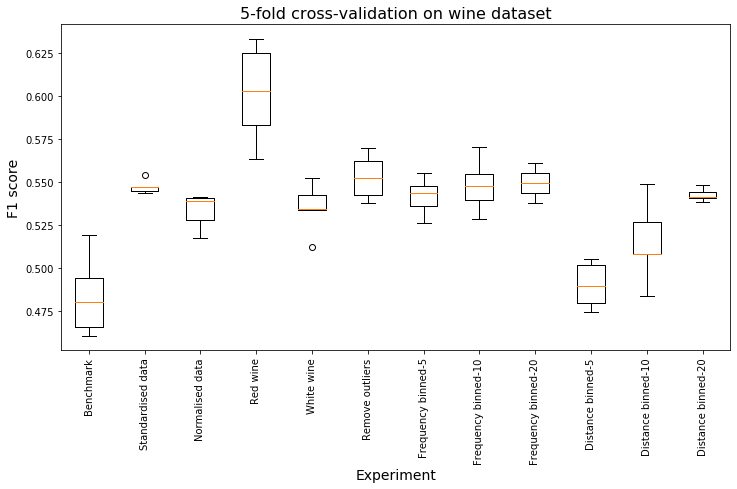

In [120]:
fig, ax = plt.subplots(figsize=(12,6))
plt.boxplot(res_c, labels=names)
plt.title('5-fold cross-validation on wine dataset', size=16)
plt.xticks(rotation='vertical')
ax.set_xlabel("Experiment", size=14)
ax.set_ylabel("F1 score", size=14)
plt.show()

#### Hyper-parameter Tuning
<font color='red'>Warning: The grid searches in this section take several hours to run</font> 

Here we use a grid search to tune model hyper-parameters.  Grid searches are combinatorial, requiring the training many models, each of which is k-fold validated so, given model training times, it is not feasible to try all possible combinations. We initially try a range of values differing from the library defaults used in previous experiments with the intention of investigating further any parameter changes that appear to improve model performance.

In [65]:
# Grid Search for hyper-parameters 1
X_exp = standardise(X, continuous_cols)


parameters = {'hidden_layer_sizes':(50, 200, 500, 1000), 
              'activation':('logistic', 'tanh'),
              'solver':('lbfgs', 'sgd'),
              'max_iter':(100, 500, 1000),
              'alpha': (1e-5, 1e-3, 1e-1)}


model = MLPClassifier(random_state=14)
clf = GridSearchCV(model, parameters, cv=5, scoring='f1_micro')
clf.fit(X_exp,y.values)


GridSearchCV(cv=5, error_score=nan,
             estimator=MLPClassifier(activation='relu', alpha=0.0001,
                                     batch_size='auto', beta_1=0.9,
                                     beta_2=0.999, early_stopping=False,
                                     epsilon=1e-08, hidden_layer_sizes=(100,),
                                     learning_rate='constant',
                                     learning_rate_init=0.001, max_fun=15000,
                                     max_iter=200, momentum=0.9,
                                     n_iter_no_change=10,
                                     nesterovs_momentum=True, power_t=0.5,
                                     random_state...
                                     solver='adam', tol=0.0001,
                                     validation_fraction=0.1, verbose=False,
                                     warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'activation': ('

#### Optimal parameters from grid search

In [67]:
clf.best_estimator_

MLPClassifier(activation='tanh', alpha=0.1, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=1000, learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=1000,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=14, shuffle=True, solver='lbfgs',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)

#### Train and evaluate optimal model determined by grid search

In [68]:
# Test hyper-parameter tuned model 1
X_exp = standardise(X, continuous_cols)


model = clf.best_estimator_
kfold = StratifiedKFold(n_splits=5, random_state=1)
metrics = cross_validate(model, X_exp, y.values.ravel(), cv=kfold, scoring = scoring)

In [72]:
name = 'Tuned 1'
tuned = update_results(name, metrics)
tuned

,Description,fit_time,score_time,test_accuracy,test_precision,test_recall,test_f1_score
0,Tuned 1,305.641334,0.02577,0.632224,0.628974,0.632224,0.629522


##### Comment
By tuning hyper-parameters, we observe a marked improvement in model performance measured by f1 score and accuracy. Of the parameters selected for the grid search, the combination of regularisation term, alpha, of 0.1, a hyperbolic tangent activation function, a quasi-Newton optimisation method, a maximum number of iterations of 1000 and a perceptron layer of 1000 nodes was found to be optimal. Note that the grid search 'chose' the largest possible maximum iteration and layer size parameters, so it is worth exploring higher values for these settings. A further grid search is conducted below.

In [74]:
# Grid Search for hyper-parameters 2
X_exp = standardise(X, continuous_cols)


parameters = {'hidden_layer_sizes':(2000,5000), 
              'activation':('tanh',),
              'solver':('lbfgs',),
              'max_iter':(2000,5000),
              'alpha': (0.1,)}


model = MLPClassifier(random_state=14)
clf = GridSearchCV(model, parameters, cv=5, scoring='f1_micro')
clf.fit(X_exp,y.values)


GridSearchCV(cv=5, error_score=nan,
             estimator=MLPClassifier(activation='relu', alpha=0.0001,
                                     batch_size='auto', beta_1=0.9,
                                     beta_2=0.999, early_stopping=False,
                                     epsilon=1e-08, hidden_layer_sizes=(100,),
                                     learning_rate='constant',
                                     learning_rate_init=0.001, max_fun=15000,
                                     max_iter=200, momentum=0.9,
                                     n_iter_no_change=10,
                                     nesterovs_momentum=True, power_t=0.5,
                                     random_state=14, shuffle=True,
                                     solver='adam', tol=0.0001,
                                     validation_fraction=0.1, verbose=False,
                                     warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'

#### Optimal parameters from grid search

In [76]:
clf.best_estimator_

MLPClassifier(activation='tanh', alpha=0.1, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=5000, learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=5000,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=14, shuffle=True, solver='lbfgs',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)

#### Train and evaluate optimal model determined by grid search

In [77]:
# Test hyper-parameter tuned model 2
X_exp = standardise(X, continuous_cols)


model = clf.best_estimator_
kfold = StratifiedKFold(n_splits=5, random_state=1)
metrics = cross_validate(model, X_exp, y.values.ravel(), cv=kfold, scoring = scoring)

In [78]:
name = 'Tuned 2'
tuned = update_results(name, metrics)
tuned

,Description,fit_time,score_time,test_accuracy,test_precision,test_recall,test_f1_score
0,Tuned 2,2438.792224,0.24433,0.627063,0.623188,0.627063,0.624274


##### Comment
Increasing the maximum number of epochs and the hidden layer size has actually resulted in a small degradation in performance as measured by f1 score and accuracy and at significant cost in terms of model train times. We'll train a single model with the previous best parameters but with two hidden layers, rather than one, to see if deeper networks might be worth exploring.

In [79]:
# Test deeper NN
X_exp = standardise(X, continuous_cols)

model = MLPClassifier(random_state=14, activation='tanh', solver='lbfgs', 
                      alpha=0.1, max_iter=1000, hidden_layer_sizes=(500,500))
kfold = StratifiedKFold(n_splits=5, random_state=1)
metrics = cross_validate(model, X_exp, y.values.ravel(), cv=kfold, scoring = scoring)
name = 'Deeper network'
tuned = update_results(name, metrics)

In [80]:
tuned

,Description,fit_time,score_time,test_accuracy,test_precision,test_recall,test_f1_score
0,Deeper network,171.789056,0.065424,0.629125,0.623108,0.629125,0.624824


##### Comment
A model with two 500-node layers has made no discernable improvement to performance compared with an identical model with a single 1000-node layer. 

#### Final model evaluation
Below we build a model with input data standardisation and hyper-parameters found to be optimal during experimentation and evaluate this on unseen data set aside at the beginning. We compare this with the benchmark model, again evaluated on the same unseen test data.

In [11]:
# Final model evaluation
X_unseen_exp = one_hot_encode(X_unseen,['type'])
X_unseen_exp = standardise(X_unseen_exp, continuous_cols)

X_exp = standardise(X, continuous_cols)

model_benchmark = MLPClassifier(random_state=14)
model_final = MLPClassifier(random_state=14, activation='tanh', solver='lbfgs', 
                      alpha=0.1, max_iter=1000, hidden_layer_sizes=(1000,))

y_pred_benchmark = model_benchmark.fit(X_exp,y).predict(X_unseen_exp)
y_pred_final = model_final.fit(X_exp,y).predict(X_unseen_exp)

By standardising input data and tuning model hyperparameters we observe improvements in both f1 score and accuracy as shown above.

In [12]:
print("Benchmark model")
print("F1 score: " + str(f1_score(y_unseen, y_pred_benchmark, average='weighted',zero_division=0).round(3)))
print("Accuracy: " + str(accuracy_score(y_unseen, y_pred_benchmark).round(3)))
print("\nFinal model")
print("F1 score: " + str(f1_score(y_unseen, y_pred_final, average='weighted',zero_division=0).round(3)))
print("Accuracy: " + str(accuracy_score(y_unseen, y_pred_final).round(3)))

Benchmark model
F1 score: 0.558
Accuracy: 0.578

Final model
F1 score: 0.609
Accuracy: 0.612


Note that we expect f1 and accuracy from the evaluation on unseen test data to be lower than those obtained from k-folds validation.

#### Plot confusion matrix
The confusion matrix below shows false and true, positive and negative predictions made by the final model.

In [198]:
labels=np.unique(y_unseen)
cm = confusion_matrix(y_unseen,y_pred_final)

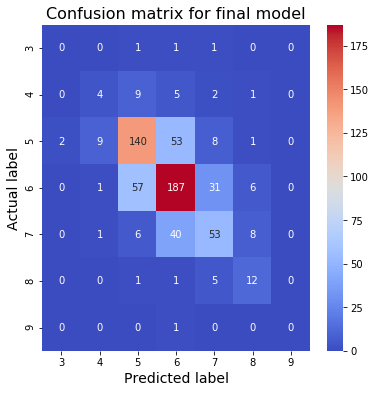

In [215]:
fig, ax = plt.subplots(figsize=(6,6))
sns.heatmap(cm, annot=True, cmap='coolwarm' ,fmt='g')
plt.ylabel('Actual label', size=14)
plt.xlabel('Predicted label', size=14)
plt.title('Confusion matrix for final model', size=16)
ax.set_xticklabels(labels)
ax.set_yticklabels(labels)
plt.show()

#### Classification Report

In [222]:
print(classification_report(y_unseen,y_pred_final))

              precision    recall  f1-score   support

           3       0.00      0.00      0.00         3
           4       0.27      0.19      0.22        21
           5       0.65      0.66      0.66       213
           6       0.65      0.66      0.66       282
           7       0.53      0.49      0.51       108
           8       0.43      0.63      0.51        19
           9       0.00      0.00      0.00         1

    accuracy                           0.61       647
   macro avg       0.36      0.38      0.36       647
weighted avg       0.61      0.61      0.61       647



##### Comment
We observe better performance for more populous classes in our dataset - wines of quality ratings 5 and 6 - although even for these, our model still makes a significant number of errors.  The model performs poorly on minority classes, misclassifying all rows for wines of quality 3 and 9 and most rows for wines of quality 4, although one cannot draw firm conclusions from this given how few examples we have in our dataset.